In [1]:
#importing packages
import warnings
warnings.filterwarnings("ignore")

import pickle
import os
import pandas as pd
import random as rn
import numpy as np
import tensorflow as tf
# tf.enable_eager_execution()

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.regularizers import l1,l2
from tqdm import tqdm
import heapq
from sklearn.utils import shuffle
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [25]:
currentDirectory = "./"
dataDirectory = currentDirectory
imageDirectory = dataDirectory + "image_data/train2014/"
val_imageDirectory = dataDirectory + "image_data/val2014/"
test_imageDirectory = dataDirectory + "image_data/test2015/" 
modelsDirectory = currentDirectory + "models/"
img_width = 224
img_height = 224

BATCH_SIZE = 64
BUFFER_SIZE = 300

In [7]:
data = pd.read_csv(dataDirectory + 'image_text_data.csv')
val_data = pd.read_csv(dataDirectory + 'val_image_text_data.csv')
test_data = pd.read_csv(dataDirectory + 'features_files/test_image_text_data.csv')

In [8]:
data.dropna(inplace = True)
val_data.dropna(inplace = True)
test_data.dropna(inplace = True)

In [9]:
contractions = { 
"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not",
"couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
"hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he's": "he is","how'd": "how did",
"how'll": "how will","how's": "how is","i'd": "i would","i'll": "i will","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would",
"it'll": "it will","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"must've": "must have","mustn't": "must not","needn't": "need not","oughtn't": "ought not","shan't": "shall not","sha'n't": "shall not","she'd": "she would",
"she'll": "she will","she's": "she is","should've": "should have","shouldn't": "should not","that'd": "that would","that's": "that is","there'd": "there had",
"there's": "there is","they'd": "they would","they'll": "they will","they're": "they are","they've": "they have","wasn't": "was not","we'd": "we would",
"we'll": "we will","we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what're": "what are","what's": "what is",
"what've": "what have","where'd": "where did","where's": "where is","who'll": "who will","who's": "who is","won't": "will not","wouldn't": "would not",
"you'd": "you would","you'll": "you will","you're": "you are"
}

def preprocess_text(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = ""
    text = text.lower()
    i = 0
    for word in text.split():
        if i==0:
            new_text = contractions.get(word,word)
        else:
            new_text = new_text + " " + contractions.get(word,word)
        i += 1
    return new_text.replace("'s", '')

In [6]:
data['multiple_choice_answer'] = data['multiple_choice_answer'].apply(lambda x: preprocess_text(x))
val_data['multiple_choice_answer'] = val_data['multiple_choice_answer'].apply(lambda x: preprocess_text(x))

In [10]:
X_train = data
X_val = val_data
X_test = test_data

del data, val_data, test_data
len(X_train), len(X_val), len(X_test)

(443757, 214353, 447793)

In [11]:
all_classes = X_train['multiple_choice_answer'].values
class_frequency = {}

for _cls in all_classes:
    if(class_frequency.get(_cls,-1)>0):
        class_frequency[_cls] += 1
    else:
        class_frequency[_cls] = 1

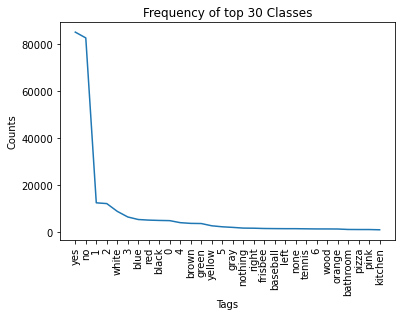

In [12]:
sort_class_frequency = sorted(list(class_frequency.items()), key = lambda x: x[1],reverse=True)   

plt.plot([x[1] for x in sort_class_frequency[:30]])
i=np.arange(30)
plt.title("Frequency of top 30 Classes")
plt.xlabel("Tags")
plt.ylabel("Counts")
plt.xticks(i,[x[0] for x in sort_class_frequency[:30]])
plt.xticks(rotation=90)
plt.show()

In [13]:
common_tags = heapq.nlargest(1000, class_frequency, key = class_frequency.get)

In [14]:
# take the top 1000 classes
X_train['multiple_choice_answer'] =  X_train['multiple_choice_answer'].apply(lambda x: x if x in common_tags else '')

# removing question which has empty tags
X_train = X_train[X_train['multiple_choice_answer'].apply(lambda x: len(x)>0)]

In [15]:
label_encoder = LabelBinarizer()
answer_vector_train = label_encoder.fit_transform(X_train['multiple_choice_answer'].apply(lambda x: x).values)
answer_vector_val = label_encoder.transform(X_val['multiple_choice_answer'].apply(lambda x: x).values)

ans_vocab = {l: i for i, l in enumerate(label_encoder.classes_)}

print("Number of clasess: ", len(ans_vocab))
print("Shape of Answer Vectors in Train Data: ", answer_vector_train.shape)
print("Shape of Answer Vectors in Validation Data: ", answer_vector_val.shape)

Number of clasess:  1000
Shape of Answer Vectors in Train Data:  (388158, 1000)
Shape of Answer Vectors in Validation Data:  (214353, 1000)


### Question vectors

In [17]:
def preprocess_question(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = "<start>"
    text = text.lower()
    for word in text.split():
        new_text = new_text + " " + contractions.get(word, word)
    new_text = new_text + " <end>"
    return new_text.replace("'s", '')

In [18]:
X_train['question'] = X_train['question'].apply(lambda x: preprocess_question(x))
X_val['question'] = X_val['question'].apply(lambda x: preprocess_question(x))

In [19]:
#tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token = "<unk>", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(X_train['question'].values)
train_question_seqs = tokenizer.texts_to_sequences(X_train['question'].values)

print("Number of words in tokenizer:", len(tokenizer.word_index))
ques_vocab = tokenizer.word_index

question_vector_train = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding='post')
print("Shape of Question Vectors in Train Data: ", question_vector_train.shape)

Number of words in tokenizer: 12450
Shape of Question Vectors in Train Data:  (388158, 24)


In [27]:
model = tf.keras.models.load_model('./final_models/final_baseline_model_50epochs.h5')

In [23]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (img_width, img_height))
    img = tf.keras.applications.vgg19.preprocess_input(img)
    img = img * (1./255)
    img = tf.expand_dims(img, axis=0)
    return img, image_path

def VGG19_Top():
    model = tf.keras.applications.VGG19(include_top=False,weights='imagenet',input_shape = (img_width, img_height,3))
    input_layer = model.input
    hidden_layer = model.layers[-1].output 
    model = tf.keras.Model(input_layer, hidden_layer)
    return model

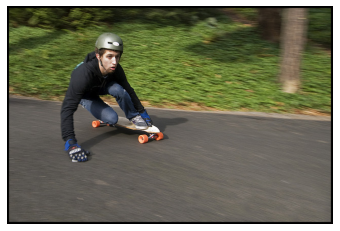

Question : Is that a normal sized skateboard?
Top Predicted answers:  [('yes', 16.205248), ('no', 11.729597), ('3', 6.3247776), ('skateboarding', 3.0000863), ('2', 2.9358945)]
****************************************************************************************************


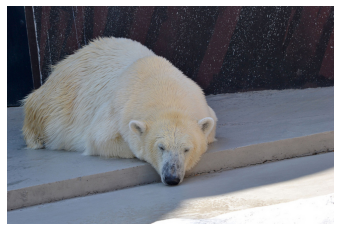

Question : What is the bear doing?
Top Predicted answers:  [('snowboarding', 5.847578), ('nothing', 3.879663), ('water', 3.4490876), ('sleeping', 3.197276), ('none', 2.837111)]
****************************************************************************************************


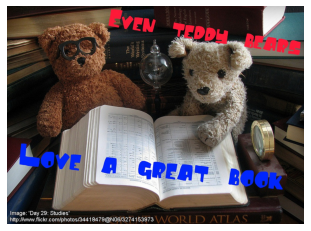

Question : Can teddy bears really read?
Top Predicted answers:  [('no', 28.407845), ('yes', 20.511751), ('none', 6.516573), ('toothbrush', 2.0855677), ('drink', 1.5522223)]
****************************************************************************************************


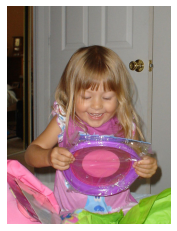

Question : Does she look happy with her item?
Top Predicted answers:  [('yes', 9.047058), ('red', 5.055268), ('apple', 4.990984), ('banana', 3.2121468), ('no', 3.059086)]
****************************************************************************************************


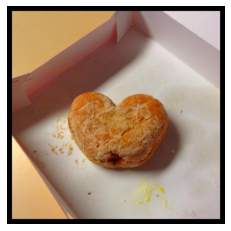

Question : How many compartments are in the container?
Top Predicted answers:  [('1', 40.891323), ('0', 19.548506), ('2', 17.48906), ('4', 6.8565326), ('3', 4.0710096)]
****************************************************************************************************


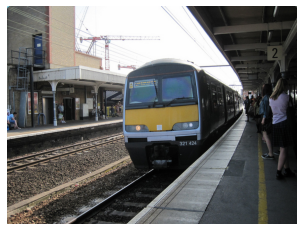

Question : Is the station empty?
Top Predicted answers:  [('yes', 21.84385), ('no', 15.641272), ('0', 2.2123427), ('umbrella', 1.8029883), ('train', 1.6891993)]
****************************************************************************************************


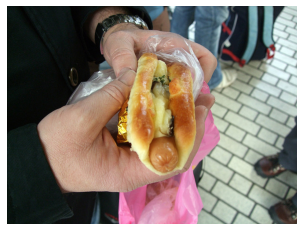

Question : Is there any cheese on the hot dog?
Top Predicted answers:  [('1', 6.653693), ('yes', 4.9314237), ('4', 4.8955255), ('no', 4.0808425), ('scissors', 3.9080853)]
****************************************************************************************************


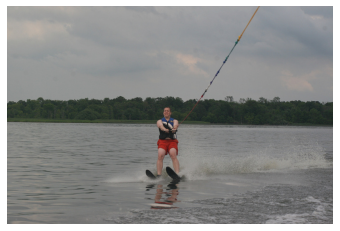

Question : Are the waters calm?
Top Predicted answers:  [('1', 13.3054285), ('yes', 6.9506245), ('0', 6.3877873), ('3', 5.820452), ('no', 4.643825)]
****************************************************************************************************


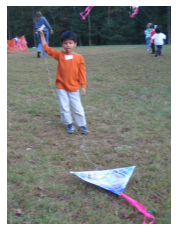

Question : What ethnicity is the boy?
Top Predicted answers:  [('white', 32.476063), ('orange', 13.680889), ('black', 9.595452), ('1', 2.9947336), ('brown', 2.992651)]
****************************************************************************************************


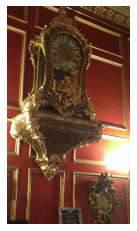

Question : What time is on the clock?
Top Predicted answers:  [('night', 8.520526), ('4', 6.3489356), ('christmas', 4.6051455), ('morning', 3.9019392), ('noon', 3.2767122)]
****************************************************************************************************


In [31]:
random.seed(42)
test_idx = np.random.randint(len(X_val), size = 10)
model_vgg = VGG19_Top()
k = 5

for idx in test_idx:
    test_image_id = X_test['image_id'].values[idx]
    test_question = X_test['question'].values[idx]
    test_image_path = test_imageDirectory + 'COCO_test2015_' + '%012d.jpg' % (test_image_id)

    test_image_features = model_vgg(load_image(test_image_path)[0], 0)
    test_question_features = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([test_question]),padding='post',
                                                                           maxlen=question_vector_train.shape[1])
    y_pred = model.predict([test_image_features,test_question_features])

    class_indices = tf.math.top_k(y_pred,k=k).indices.numpy()
    percentages = tf.math.top_k(y_pred,k=k).values.numpy()[0] * 100
    predictions = []
    for idx,i in enumerate(class_indices[0]):
        classes = np.zeros((1,1000))
        classes[0][i] = 1
        predictions.append((label_encoder.inverse_transform(classes)[0],percentages[idx]))

    img = mpimg.imread(test_image_path)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

    print("Question :", test_question.replace("<start> ","").replace(" <end>",""))
    print("Top Predicted answers: ",predictions)
    print("*"*100)

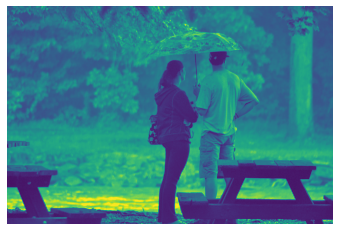

Question : what is the man holding up to his head?
Actual Answer:  umbrella
Top Predicted answers:  [('umbrella', 25.993807), ('frisbee', 21.899303), ('kite', 14.933836), ('camera', 3.8482006), ('hat', 3.7248611)]
******************************************************************************************************************************************************


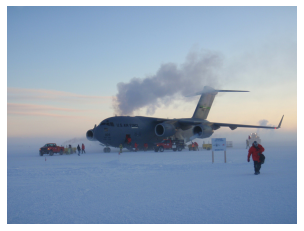

Question : is this man catching a plane?
Actual Answer:  no
Top Predicted answers:  [('no', 53.486824), ('yes', 46.409306), ('none', 0.003318166), ('scissors', 0.0015494934), ('surfing', 0.0012718659)]
******************************************************************************************************************************************************


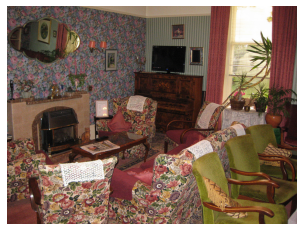

Question : what pattern is the wall?
Actual Answer:  floral
Top Predicted answers:  [('solid', 39.04209), ('floral', 32.270714), ('stripes', 6.9308014), ('flowers', 6.58785), ('checkered', 5.1225953)]
******************************************************************************************************************************************************


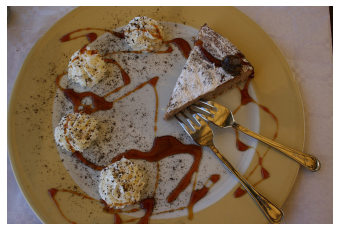

Question : what is this dish?
Actual Answer:  cheesecake
Top Predicted answers:  [('pizza', 29.173105), ('vegetables', 13.997863), ('cake', 8.597785), ('fruit', 5.5020885), ('donut', 4.2317758)]
******************************************************************************************************************************************************


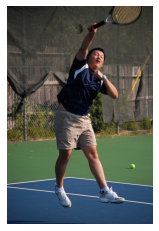

Question : is the man feet on the ground?
Actual Answer:  no
Top Predicted answers:  [('no', 51.087784), ('yes', 48.86434), ('tennis', 0.0017795159), ('tennis racket', 0.001724131), ('bat', 0.0015904267)]
******************************************************************************************************************************************************


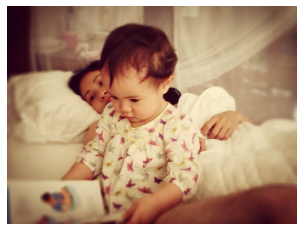

Question : is there a man and woman in the picture?
Actual Answer:  no
Top Predicted answers:  [('no', 50.04071), ('yes', 49.619434), ('phone', 0.011751097), ('girl', 0.010013186), ('sandwich', 0.009208969)]
******************************************************************************************************************************************************


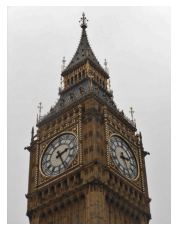

Question : are there crosses on the tower?
Actual Answer:  yes
Top Predicted answers:  [('yes', 51.500175), ('no', 48.48211), ('2', 0.00086949475), ('on building', 0.0006986867), ('0', 0.0005473929)]
******************************************************************************************************************************************************


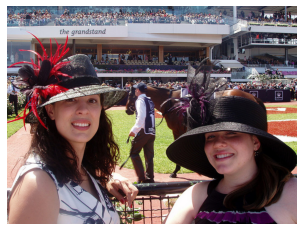

Question : what color is the horse?
Actual Answer:  brown
Top Predicted answers:  [('brown', 90.28472), ('white', 2.8006978), ('gray', 2.331868), ('brown and white', 1.9173906), ('black', 0.5999925)]
******************************************************************************************************************************************************


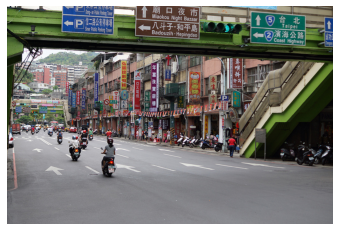

Question : are the motorcycles heeding the traffic signs?
Actual Answer:  yes
Top Predicted answers:  [('yes', 70.60893), ('no', 29.371595), ('bicycles', 0.00036875255), ('art', 0.00033348412), ('chinese', 0.00030519156)]
******************************************************************************************************************************************************


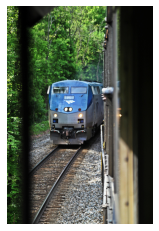

Question : what colors are the train?
Actual Answer:  blue and gray
Top Predicted answers:  [('blue and yellow', 16.753162), ('black', 11.6085005), ('blue and white', 8.720357), ('red and yellow', 6.945801), ('blue', 5.620216)]
******************************************************************************************************************************************************


In [30]:
random.seed(42)
test_idx = np.random.randint(len(X_val), size = 10)
model_vgg = VGG19_Top()
k = 5

for idx in test_idx:
    test_image_id = X_val['image_id'].values[idx]
    test_question = X_val['question'].values[idx]
    actual_answer = X_val['multiple_choice_answer'].values[idx]
    test_image_path = val_imageDirectory + 'COCO_val2014_' + '%012d.jpg' % (test_image_id)

    test_image_features = model_vgg(load_image(test_image_path)[0], 0)
    test_question_features = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([test_question]),padding='post',
                                                                           maxlen=question_vector_train.shape[1])
    y_pred = model.predict([test_image_features,test_question_features])

    class_indices = tf.math.top_k(y_pred,k=k).indices.numpy()
    percentages = tf.math.top_k(y_pred,k=k).values.numpy()[0] * 100
    predictions = []
    for idx,i in enumerate(class_indices[0]):
        classes = np.zeros((1,1000))
        classes[0][i] = 1
        predictions.append((label_encoder.inverse_transform(classes)[0],percentages[idx]))

    img = mpimg.imread(test_image_path)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

    print("Question :", test_question.replace("<start> ","").replace(" <end>",""))
    print("Actual Answer: ", actual_answer)
    print("Top Predicted answers: ",predictions)
    print("*"*100)